# Hellcase - Data Scrape and Probability Manipulation

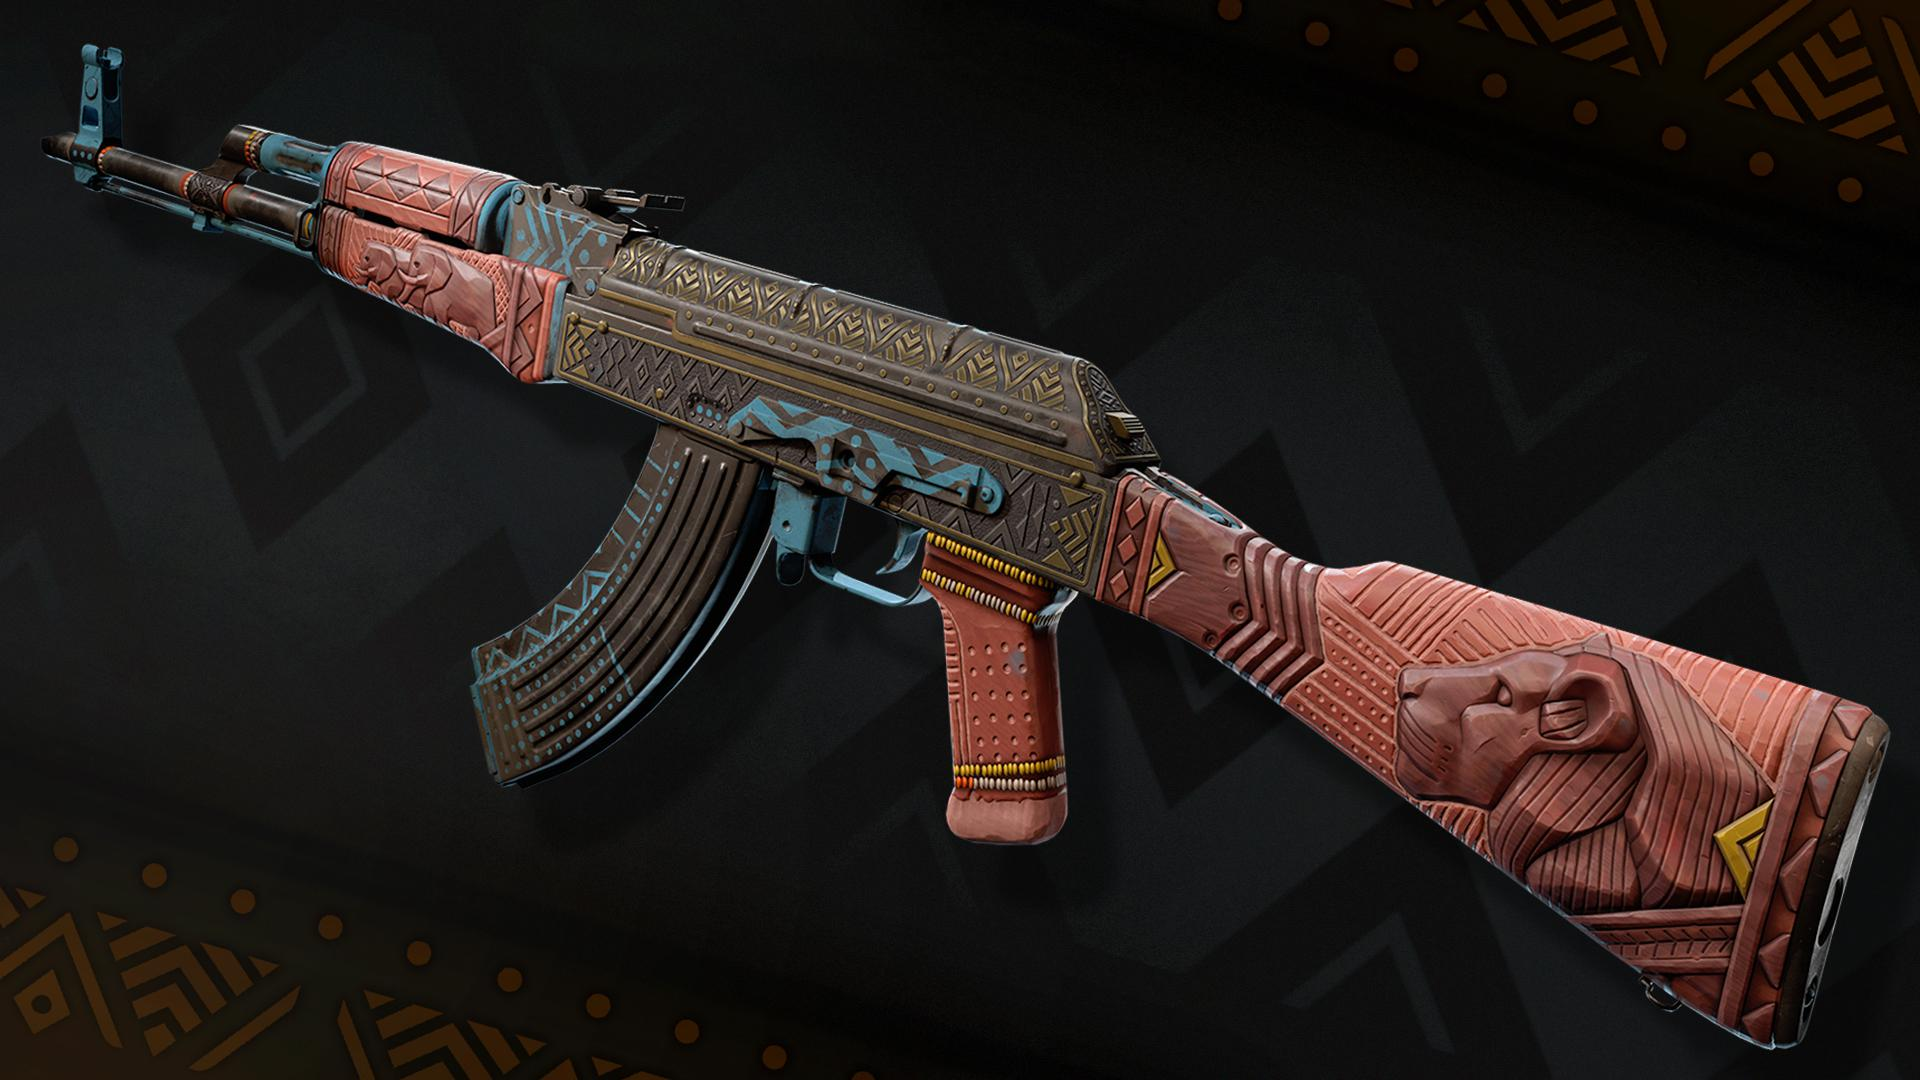

## Table of Contents

* [Intro](#Intro)
* [Import Libraries](#Part-1:-Import-Libraries)
* [First Scrape](#Part-2:-First-Scrape)
* [Create Depdendencies](#Part-3:-Create-Dependencies)
* [Second Scrape](#Part-4:-Second-Scrape)
* [Data Analysis](#Part-5:-Data-Analysis)
* [Conclusions](#Conclusions)
* [Shortcomings and Potential Improvements](#Shortcomings-and-Potential-Improvements)
* [Detailed Step-by-Step Walkthrough](#Detailed-Step-by-Step-Walkthrough)

## Intro

Counter-Strike 2(CS2), formerly known as Counter-Strike Global Offensive(CS:GO) is one of the most popular video games in the world. Boasting a record of 1.8 MILLION concurrent players, to say it is wildly successful would be an understatement.  
A huge part of this success came when Valve, the company that made CS:GO, introduced the "Arms Deal" update, which introduced weapon skins to the game. These skins saw tremendous success overnight.  
Online personalities that dedicated their entire online presence to these skins garnered instant fame, websites that handled intra-player skin trading launched, and some skins were being sold for upwards of $600,000!  
  
As with most innocenet beginnings, certain bad-faith players have to enter the arena and one of these examples, in my opinion, would be the popular skins gambling website: Hellcase.  
Hellcase is an online website where users gamble on CS:GO skins using their hard-earned cash. Claims of "Provably Fair" are plastered all over the website, but I had my inclination that something was off, so I decided to take a deep dive into this.  
  
To simplify how Hellcase is set-up, for the most part, what you need to know is they have created their own version of cases. Each case carries it's own price. These cases carry a number of skins that vary in price and the chance to pull certain skins vary (More expensive skins tend to be harder to pull than the cheaper ones). There are other game modes that one can dabble with on Hellcase, but I won't include those in this analysis.  

Because of the format of the code, I have to run lots of lines simultaneously, so I couldn't break up the code to explain as I go. For this reason, I included a [Detailed Step-by-Step Walkthrough](#Detailed-Step-by-Step-Walkthrough) section towards the end of this notebook.  
  
I hope you enjoy this piece and make sure to take a look at the conclusions section for some eye-opening analysis!

## Part 1: Import Libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd
import numpy as np
from urllib.parse import urlparse, parse_qs

## Part 2: First Scrape

In [3]:
# Connect to Browser
url = 'https://hellcase.com/en#case'
driver = webdriver.Chrome()
driver.get(url)
time.sleep(8)

# Scrape Each Category Class Name
category_elements = driver.find_elements(By.CLASS_NAME, 'main-page-cases-categories-item')
categories = {}
category_classes = []


for element in category_elements:
    class_attribute = element.get_attribute('class')
    classes = class_attribute.split(' ')
    if len(classes) > 1:
        category_class = classes[1]  # Assuming the unique category class is always the second class
        categories[category_class] = []  # Initialize an empty list for each category

# Iterate over categories to scrape URLs
for category_class in categories.keys():
    # Find all category elements again
    category_elements = driver.find_elements(By.CLASS_NAME, 'main-page-cases-categories-item')
    
    for category_element in category_elements:
        if category_class in category_element.get_attribute('class').split(' '):
            # Assuming each case within a category has an <a> tag with the URL
            case_links = category_element.find_elements(By.TAG_NAME, 'a')
            for link in case_links:
                categories[category_class].append(link.get_attribute('href'))
            break
    
driver.quit()

## Part 3: Create Dependencies

In [4]:
# Creating Final Dataframe

df_final = pd.DataFrame(columns=
                        ['Case Name', 'Cost of Case', 'Total Expected Value', 'Profitability', 'Profitability (%)'])

In [5]:
data = []

In [23]:
if 'cat-farm' in categories:
    del categories['cat-farm']
if 'cat-stickers' in categories:
    del categories['cat-stickers']

## Part 4: Second Scrape

In [28]:
for category, urls in categories.items():
    print(f"Starting scrape of the following category: {category}")
    for url in urls:
        try:
            case_name = urlparse(url).path.split('/')[-1]
            print(f"Case Name: {case_name}")
            driver = webdriver.Chrome()
            driver.get(url)
            time.sleep(10)

            # Creating lists we will use
            wear = []
            price = []
            drops = []
            name = []
            num_rows = []

            # Finding the range of number of different skins in each case
            num_weapons = len(driver.find_elements(By.XPATH, '//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a'))

            # Finding the cost of the case
            cost_of_case = driver.find_element(By.XPATH, '//*[@id="main-content"]/div[1]/div[1]/div[4]/div[2]/button/div').text
            cost_of_case = str(cost_of_case[2:])
            cost_of_case = float(cost_of_case)

            # Getting the name of each skin:
            for i in range(num_weapons):
                weapon_name = driver.find_element(By.XPATH, f'//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a[{i + 1}]/div[3]/div[4]/div[2]').text
                name.append(weapon_name)

            # Clicking all the buttons to open data tables
            for i in range(num_weapons):
                try:
                    first_xpath = f'//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a[{i+1}]/div[2]/div[2]'
                    all_skins_button = driver.find_element(By.XPATH, first_xpath)
                except NoSuchElementException:
                    second_xpath = f'//*[@id="main-content"]/div[1]/div[3]/div[2]/div[2]/section/div/a[{i+1}]/div[2]/div[2]'
                    all_skins_button = driver.find_element(By.XPATH, second_xpath)
                all_skins_button.click()

            # Getting the columns for our data frame
            tables = driver.find_elements(By.TAG_NAME, 'tbody')

            for table in tables:
                ActionChains(driver).move_to_element(table).perform()
                count_rows = table.find_elements(By.TAG_NAME, 'tr')
                num_rows1 = len(count_rows)
                num_rows.append(num_rows1)
                rows = table.find_elements(By.TAG_NAME, 'tr')

                for row in rows:
                    columns = row.find_elements(By.TAG_NAME, 'td')

                    if len(columns) >= 3:
                        wear_text = columns[0].text
                        is_stattrak = row.get_attribute('class') == 'stattrak'

                        if is_stattrak:
                            wear_text += ' ST'

                        wear.append(wear_text)
                        price.append(columns[1].text)
                        drops.append(columns[2].text)


            final_names = sum([[s] * n for s, n in zip(name, num_rows)], [])

            df = pd.DataFrame({'Case Name': case_name, 'Cost of Case': cost_of_case, 'Name': final_names, 'Wear': wear, 'Price': price, 'Drop Rate': drops})

            # Data Cleaning
            df = df.replace(r'\n', ' ', regex= True)
            df['Price'] = df['Price'].str[2:].astype(float)
            df['Drop Rate'] = df['Drop Rate'].str[:-1].astype(float)
            df['Drop Rate'] = df['Drop Rate']/100
            df['Expected Value'] = df['Price'] * df['Drop Rate']

            total_expected_value = np.sum(df['Expected Value'])
            profitability = total_expected_value - cost_of_case
            profitability_perc = (profitability/cost_of_case)*100

            # Append data to list
            data_dict = {
                'Case Name': case_name,
                'Cost of Case': cost_of_case,
                'Total Expected Value': total_expected_value,
                'Profitability': profitability,
                'Profitability (%)': profitability_perc
            }
            data.append(data_dict)
            
            print(f'Scraping of {case_name} is complete, moving on.')
            
        except NoSuchElementException:
            print(f"Failed to scrape {case_name}, moving on.")
            continue
            
        except ValueError:
            print(f"Failed to scrape {case_name}, moving on.")
            continue
            
        driver.quit()
        
df_iteration = pd.DataFrame(data)
df_final = pd.concat([df_final, df_iteration], ignore_index=True)

Starting scrape of the following category: cat-discounts
Case Name: restricted


AttributeError: 'NoneType' object has no attribute 'click'

## Part 5: Data Analysis

In [11]:
# Quick look at what the Data looks like
df_final

,Case Name,Cost of Case,Total Expected Value,Profitability,Profitability (%)
0,restricted,1.76,1.514252,-0.245748,-13.962977
1,m4,4.62,3.972280,-0.647720,-14.019923
2,200kk,8.18,7.034063,-1.145937,-14.009007
3,premium,32.56,28.001856,-4.558144,-13.999215
4,onitaiji,92.40,79.462430,-12.937570,-14.001699
...,...,...,...,...,...
297,phoenix,1.50,1.289999,-0.210001,-14.000049
298,weapon-2,9.00,7.740020,-1.259980,-13.999781
299,weapon-3,6.00,5.160005,-0.839995,-13.999916
300,vanguard,1.50,1.289994,-0.210006,-14.000399


In [17]:
# Drop duplicate rows
df_final.drop_duplicates(inplace=True)
df_final

,Case Name,Cost of Case,Total Expected Value,Profitability,Profitability (%)
0,restricted,1.76,1.514252,-0.245748,-13.962977
1,m4,4.62,3.972280,-0.647720,-14.019923
2,200kk,8.18,7.034063,-1.145937,-14.009007
3,premium,32.56,28.001856,-4.558144,-13.999215
4,onitaiji,92.40,79.462430,-12.937570,-14.001699
...,...,...,...,...,...
297,phoenix,1.50,1.289999,-0.210001,-14.000049
298,weapon-2,9.00,7.740020,-1.259980,-13.999781
299,weapon-3,6.00,5.160005,-0.839995,-13.999916
300,vanguard,1.50,1.289994,-0.210006,-14.000399


In [18]:
# Sort by worst to best odds of turning a profit
df_final.sort_values(by=['Profitability (%)'], ascending = True)

,Case Name,Cost of Case,Total Expected Value,Profitability,Profitability (%)
133,awp,4.50,3.420537,-1.079463,-23.988070
92,usp,1.50,1.154964,-0.345036,-23.002392
116,milspec,0.30,0.248989,-0.051011,-17.003780
285,glovecase,2.00,1.679826,-0.320174,-16.008702
104,knifelife,9.00,7.560161,-1.439839,-15.998207
...,...,...,...,...,...
132,glock,1.50,1.290289,-0.209711,-13.980729
129,covert,7.35,6.322802,-1.027198,-13.975489
0,restricted,1.76,1.514252,-0.245748,-13.962977
271,falchion,1.50,1.290618,-0.209382,-13.958797


In [19]:
# Sort by best to worst odds of turning a profit
df_final.sort_values(by=['Profitability (%)'], ascending = False)

,Case Name,Cost of Case,Total Expected Value,Profitability,Profitability (%)
114,pandaknife,144.00,132.479771,-11.520229,-8.000159
271,falchion,1.50,1.290618,-0.209382,-13.958797
0,restricted,1.76,1.514252,-0.245748,-13.962977
129,covert,7.35,6.322802,-1.027198,-13.975489
132,glock,1.50,1.290289,-0.209711,-13.980729
...,...,...,...,...,...
104,knifelife,9.00,7.560161,-1.439839,-15.998207
285,glovecase,2.00,1.679826,-0.320174,-16.008702
116,milspec,0.30,0.248989,-0.051011,-17.003780
92,usp,1.50,1.154964,-0.345036,-23.002392


In [21]:
# Find the average odds of making a profit
df_final['Profitability (%)'].mean()

-14.133295012110324

## Conclusions:

### 1) The odds are S**t!
#### Sorry for my french, but by taking a look at the percent profitability, we can see that your odds of turning a profit while gambling on this website are horrendously low.
#### On average, if you are choosing random cases, you will return 86 cents for every $1.00 you spend. If you have looked at the data and found the case with the best odds, you are still losing 8 cents per dollar on average!

### 2) But wait! There's More!
#### On top of the low profit odds, hellcase dabbles in more shady practices. Let's assume you somehow managed to beat the odds and your 5.00 dollar bet turned into a skin worth a HUNDRED dollars (woohoo). When you come to cash out the skin, there is a chance that hellcase does not have that specific skin in their inventory, so you are offered several other skins that have equal to or less value than the skin you won. If you pick a skin worth 92.00 dollars, you end up with 8.00 dollars remaining in your account that you HAVE to gamble with or just keep there forever. Finally, the plethora of scammers that will try to add you as soon as they see you won big is mind-boggling (There is a ribbon that displays all big wins, with the user's name on the side).

#### Overall, I definitely would NOT recommend anyone use this website for the reasons I mentioned above!

## Shortcomings and Potential Improvements

### The script takes forever.
#### I am sure there are ways I can write the code more efficiently, or different packages I can use to scrape different parts, but as things stand, this scrape takes around an hour and a half to run.

### The website constantly changes.
#### Whether it is to keep the website looking fresh for the users, or to particularly avoid scrapers like this, Hellcase constantly changes the layout of the website which means the code needs to constantly be updated

### Didn't include all game modes.
#### There are certain game modes and cases that I didn't include in this scrape. The reason is that these cases are a minority and would require me to spend the same time of effort for less than 10% of the cases. It is definitely on my to-do list though.

## Detailed Step-by-Step Walkthrough 

### Part 1:First Scrape


This code allows us to Launch the browser with the target website (the one that contains all the cases). Once the website is launched, I set a sleep timer of 8 seconds. This allows the page to fully load before the scraping begins
```
url = 'https://hellcase.com/en#case'
driver = webdriver.Chrome()
driver.get(url)
time.sleep(8)
```

Although this part is not necessary for the overall project, I wanted to include it because it can come in handy and make life a lot easier in the future for specific requests.
The cases are divided into separate categories. What this code does is scrapes the name of each category and stores it in a list. This is useful because there are certain categories we just want to drop (Coming in the next few parts), or if you are only interested in one category!
```
category_elements = driver.find_elements(By.CLASS_NAME, 'main-page-cases-categories-item')
categories = {}
category_classes = []

for element in category_elements:
    class_attribute = element.get_attribute('class')
    classes = class_attribute.split(' ')
    if len(classes) > 1:
        category_class = classes[1]
        categories[category_class] = []
```

This line of code iterates through each category and grabs all the URL of all the cases in that category and appends them into a list inside a dictionary. 
The dictionary will have the following format: categories = {'Category_1' : ['URL1', 'URL2', 'URL3'], 'Category_2' : ['URL1, URL2, URL3, URL4, URL5], 'Category_3 : [URL1, URL2], etc.}
```
for category_class in categories.keys():
    category_elements = driver.find_elements(By.CLASS_NAME, 'main-page-cases-categories-item')
    
    for category_element in category_elements:
        if category_class in category_element.get_attribute('class').split(' '):
            case_links = category_element.find_elements(By.TAG_NAME, 'a')
            for link in case_links:
                categories[category_class].append(link.get_attribute('href'))
            break
```

This causes the driver and browser to quit once everything is done
```   
driver.quit()
```

### Part 2: Create Dependencies


We create this empty dataframe that we will append different iterations of the dataframe to in the next step. This acts as a barebones for the final dataframe.
```
df_final = pd.DataFrame(columns=
                        ['Case Name', 'Cost of Case', 'Total Expected Value', 'Profitability', 'Profitability (%)'])
```                        

We create an empty list that we will append the data from each case to in the next part
```
data = []
```

This line of code is to remove the categories that are not of interest
```
if 'cat-farm' in categories:
    del categories['cat-farm']
if 'cat-stickers' in categories:
    del categories['cat-stickers']
```

### Part 3: Second Scrape


We start off with a for loop that iterates through each category AND through each URL in that category.
I added a print statement because the scrape takes very long, it was useful to check on the progress and make sure it is still running and didn't break.
```
for category, urls in categories.items():
    print(f"Starting scrape of the following category: {category}")
```

This is the for loop that iterates through every URL.
I first added a Try,Except clause. This was important because there are certain cases with unique quirks that the scraper can't scrape. It is not feasible to manually check every case and remove the URLs so I decided to use a Try, Except to just disregard the cases that can't be scraped.
I set a sleep timer of 10 seconds because as the scrape takes more time, there is a higher chance of Memory (RAM) leaks so I wanted to stay on the safe side and give it as much time as possible.
I then create 5 lists that are empty. Each skin has 5 important attributes:

* Wear: The condition that the skins is in. Examples: FN = Factory New, MW = Minimal Wear, FT = Field Tested, WW = Well-Worn, and BS = Battle Scarred. Some skins also have a feature called Stat Trak (ST). This feature adds a small digital counter to the skin that shows how many eliminations a player got with that skin.
* Price: The cost of the skin
* Drops: The drop-rate of that specific skin in that specific wear
* Name: The name of that skin
* num_rows: This represents how many different versions of the same skin there is. Example: FN, FN ST, MW, MW ST, WW, FT, BS, BS ST would be 8 rows. This will be used as a multiplier later on to create the proper number of rows of the data frame
```
    for url in urls:
        try:
            case_name = urlparse(url).path.split('/')[-1]
            print(f"Case Name: {case_name}")
            driver = webdriver.Chrome()
            driver.get(url)
            time.sleep(10)

            wear = []
            price = []
            drops = []
            name = []
            num_rows = []
```

Each case contains an unknown number of skins. This code counts the number of skins in each case. We will use that number as a range later on in the script to iterate over
```
            num_weapons = len(driver.find_elements(By.XPATH, '//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a'))
```

This line of code captures the cost of each case. The XPATH I used grabs the cost with the dollar sign so I strip it in line 3. Finally I cast is as a float.
```
            cost_of_case = driver.find_element(By.XPATH, '//*[@id="main-content"]/div[1]/div[1]/div[4]/div[2]/button/div').text
            cost_of_case = str(cost_of_case[2:])
            cost_of_case = float(cost_of_case)
```

This is where I use the range of the number of skins to grab each weapon name and append it to the name list.
```
            for i in range(num_weapons):
                weapon_name = driver.find_element(By.XPATH, f'//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a[{i + 1}]/div[3]/div[4]/div[2]').text
                name.append(weapon_name)
```

The website include the odds of each wear of each skin but it is hidden behind a button that has to be pressed for it to appear.
This line of code goes through each skin, and click the button to show the odds.
I added a Try, Except here because once you click through enough skins and the website scrolls down, a pop-up appears, changing the XPATH of the button that needs to be pressed.
Here is a gif showing how this process looks like:
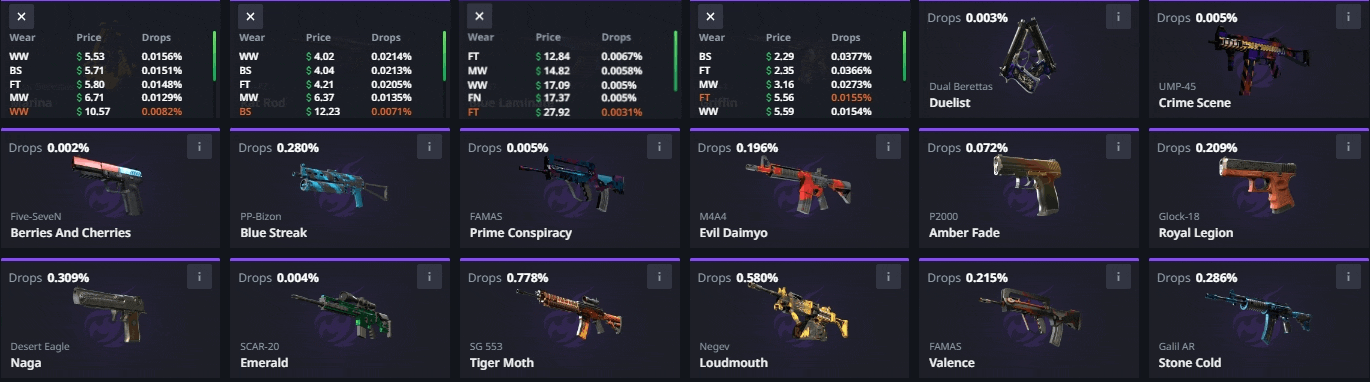
```
            for i in range(num_weapons):
                try:
                    first_xpath = f'//*[@id="main-content"]/div[1]/div[2]/div[2]/div[2]/section/div/a[{i+1}]/div[2]/div[2]'
                    all_skins_button = driver.find_element(By.XPATH, first_xpath)
                except NoSuchElementException:
                    second_xpath = f'//*[@id="main-content"]/div[1]/div[3]/div[2]/div[2]/section/div/a[{i+1}]/div[2]/div[2]'
                    all_skins_button = driver.find_element(By.XPATH, second_xpath)
                all_skins_button.click()
```

Once all the buttons are clicked, a table tbody element will show up for each skin with the attributes we are after.
The first line of codes finds all the tbody elements. 
We iterate through each tables in a for loop.
The first part of the for loop allows us to scroll through that table. This is important because if we don't scroll, the scraper can't see the entire table. I have also included a GIF of how this process works!

We count how many rows there are by locating the tr elements and append them to the empty list we created earlier num_rows.
We iterate through each row (Which represents a singular version of that skin, for example, A Minimal Wear Prince AWP) and find all the columns for that row. 
The columns contain information such as Name of Wear, Price, and Drop Rate.
    
We then look for a class attribute called Stattrak. If it exists, we add 'ST' to the wear. For example A Stat trak Minimal Wear Prince AWP would have 'MW ST' for it's wear.
    
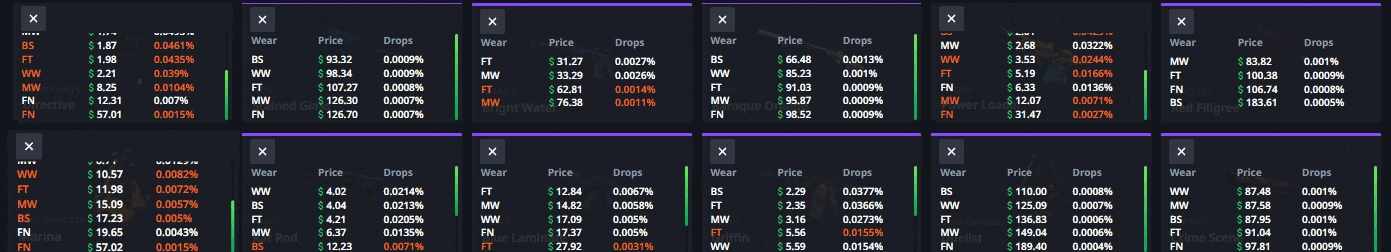
```
            tables = driver.find_elements(By.TAG_NAME, 'tbody')

            for table in tables:
                ActionChains(driver).move_to_element(table).perform()
                count_rows = table.find_elements(By.TAG_NAME, 'tr')
                num_rows1 = len(count_rows)
                num_rows.append(num_rows1)
                rows = table.find_elements(By.TAG_NAME, 'tr')

                for row in rows:
                    columns = row.find_elements(By.TAG_NAME, 'td')

                    if len(columns) >= 3:
                        wear_text = columns[0].text
                        is_stattrak = row.get_attribute('class') == 'stattrak'

                        if is_stattrak:
                            wear_text += ' ST'
```
    
We append the wear, price, and drop rate to their respective lists.
This is also where the number of rows I mentioned earlier comes to play. We want to duplicate the name of the skin by the amount of versions the skin has. That is what the final_names variable does.
Create a data frame from all the lists that are now populated for that specific case
```
                        wear.append(wear_text)
                        price.append(columns[1].text)
                        drops.append(columns[2].text)


            final_names = sum([[s] * n for s, n in zip(name, num_rows)], [])

            df = pd.DataFrame({'Case Name': case_name, 'Cost of Case': cost_of_case, 'Name': final_names, 'Wear': wear, 'Price': price, 'Drop Rate': drops})
```

Here we do some rudimentary data cleaning. 
```
            df = df.replace(r'\n', ' ', regex= True)
            df['Price'] = df['Price'].str[2:].astype(float)
            df['Drop Rate'] = df['Drop Rate'].str[:-1].astype(float)
            df['Drop Rate'] = df['Drop Rate']/100
```

This is where the bulk of our analysis will come from.
First I create a column called Expected Value which is Price x Drop Rate.
I then create a Total Expected Value, which will aggregate the Expected Value of each drop (each unique wear of each unique skin) into a Total.
Using the Total Expected Value, we can find the profitability of the case. Profitability = Total Expected Value - Cost of the Case.
Finally, we convert Profitability into a percent.
```
            df['Expected Value'] = df['Price'] * df['Drop Rate']
            total_expected_value = np.sum(df['Expected Value'])
            profitability = total_expected_value - cost_of_case
            profitability_perc = (profitability/cost_of_case)*100
```

Create a dictionary that will house the overall information per case and append it to the data list we created as a dependency.
I added a print complete statement as a sanity check.
```
            data_dict = {
                'Case Name': case_name,
                'Cost of Case': cost_of_case,
                'Total Expected Value': total_expected_value,
                'Profitability': profitability,
                'Profitability (%)': profitability_perc
            }
            data.append(data_dict)
            
            print(f'Scraping of {case_name} is complete, moving on.')
```

These are the except elements I included to make sure the scraper doesn't break when it runs into an issue and instead to just keep going.
```
        except NoSuchElementException:
            print(f"Failed to scrape {case_name}, moving on.")
            continue
            
        except ValueError:
            print(f"Failed to scrape {case_name}, moving on.")
            continue
```

Quit the driver and append the data into the df_final dependency we created earlier on. 
Once that is done, the scraper will iterate through every case in every category until it is done.
```
        driver.quit()
        
df_iteration = pd.DataFrame(data)
df_final = pd.concat([df_final, df_iteration], ignore_index=True)
```